# Linear Models
## Introduction
Linear models form one of the foundational pillars of statistical learning. Their simplicity, interpretability, and strong theoretical underpinnings make them an essential first step when analyzing data and building predictive models. Despite their apparent simplicity, linear models offer a surprising level of flexibility, especially when combined with feature transformations such as polynomials or radial basis functions.

In this chapter, we explore the principles and practical implementation of linear models. We begin with the generation of synthetic multivariate data to simulate a controlled environment for experimentation. We then dive into the manual computation of the Ordinary Least Squares (OLS) solution using matrix algebra, before comparing our results to those produced by well-established Python libraries such as `statsmodels`.

The chapter also highlights the importance of residual analysis for model diagnostics, offering tools to detect violations of assumptions like linearity, homoscedasticity, and normality. We further extend the linear model framework through input transformations, allowing us to capture non-linear patterns while preserving the model's linear structure in parameters.

Finally, we introduce **Ridge Regression**, a regularized variant of linear regression, and examine its role in mitigating overfitting—particularly in scenarios involving multicollinearity or high-dimensional input spaces.

We now assume basic familiarity with matrix algebra and Python packages such as `NumPy`, `Pandas`, and `Statsmodels`.

```{margin}
Don't forget: if some of those libraries are not installed on your computer, you can always install them using [Pip](http://pypi.org). 
```

We define the necessary imports as well as the `pprint` function.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import probplot
from IPython.display import display, Math
from numpyarray_to_latex.jupyter import to_ltx
import matplotlib.pyplot as plt
plt.style.use(['seaborn-v0_8-muted', 'practicals.mplstyle'])
def pprint(*args):
    res = ""
    for i in args:
        if type(i) == np.ndarray:
            res += to_ltx(i, brackets='[]')
        elif type(i) == str:
            res += i
    display(Math(res))

## Generating Synthetic Multivariate Data
We'll create a dataset where `Y` depends on three features: `X1, X2, X3`.
The true data-generating process (DGP) is:

$$
  Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3 + \epsilon,
$$
where $\epsilon \sim \mathcal{N}(0, \sigma^2)$.

### Exercise
1. Create `N` observations of `(X1, X2, X3)`.
2. Define true coefficients `beta_true`.
3. Generate noise and produce `Y`.
4. Store everything in a DataFrame for convenience.

#### Solution
The following code generates a synthetic dataset for a linear regression problem with three explanatory variables ($\mathbf X_1$, $\mathbf X_2$, $\mathbf X_3$) and one target variable ($\mathbf Y$). It sets a random seed for reproducibility and defines true regression coefficients (`beta_true`) and a standard deviation for the noise (`sigma_true`). The explanatory variables are drawn from different distributions: uniform for $\mathbf X_1$ and $\mathbf X_2$, and normal for $\mathbf X_3$. The true response `Y_true` is computed as a linear combination of the variables with the defined coefficients, and Gaussian noise is added to simulate observed values of $\mathbf Y$. The resulting dataset, stored in a `pandas` DataFrame, includes the predictors and the noisy target variable, and the first few rows are displayed using `df.head()`.

In [2]:
np.random.seed(123)

N = 200
sigma_true = 2.0

beta_true = np.array([5.0, 1.5, -2.0, 0.5])

X1 = np.random.uniform(-5, 5, size=N)
X2 = np.random.uniform(-10, 10, size=N)
X3 = np.random.normal(0, 2, size=N)

df = pd.DataFrame({'X1':X1, 'X2':X2, 'X3':X3})

Y_true = (beta_true[0]
          + beta_true[1]*df['X1']
          + beta_true[2]*df['X2']
          + beta_true[3]*df['X3'])

noise = np.random.normal(0, sigma_true, size=N)
df['Y'] = Y_true + noise

df.head()

,X1,X2,X3,Y
0,1.964692,0.852719,-3.510804,5.687964
1,-2.138607,-8.664511,-0.697215,16.509223
2,-2.731485,3.067297,-0.385230,-4.050829
3,0.513148,9.921727,0.898271,-12.453060
4,2.194690,5.387947,-0.290727,-1.697682


### Quick Data Inspection
The following code performs exploratory data analysis on a DataFrame `df`. It first prints summary statistics of the DataFrame using `df.describe()`, which includes metrics like mean, standard deviation, min, and max for each numerical column. Then, it creates a pairplot using Seaborn with regression lines (`kind='reg'`) to visualize pairwise relationships between all numerical features in the DataFrame. The regression lines are colored red, as specified in the `plot_kws`. A title is added slightly above the plot using `plt.suptitle()`, and finally, the complete visualization is displayed with `plt.show()`.

```{margin}
Doing a first data inspection is extremely important. In real-life cases, you could discover patterns in the data, discard particular features, or even, sometimes, solve the problem you are tackling just by extracting visual information by the data. This step also helps understanding the problem you are dealing with. The more visualization of the data you make, the more expert you become on the dataset. Never underestimate the importance of the base knowledge of the problem: _data is more than just numbers_.
```

               X1          X2          X3           Y
count  200.000000  200.000000  200.000000  200.000000
mean     0.032708   -0.193044   -0.112239    5.572700
std      2.663947    5.907073    1.963533   12.473036
min     -4.973119   -9.929356   -5.262876  -20.342999
25%     -1.953937   -5.254828   -1.286318   -4.258475
50%      0.207716   -0.714124   -0.101728    5.417761
75%      2.181854    5.168943    1.206797   14.861563
max      4.953585    9.921727    4.501352   30.849943


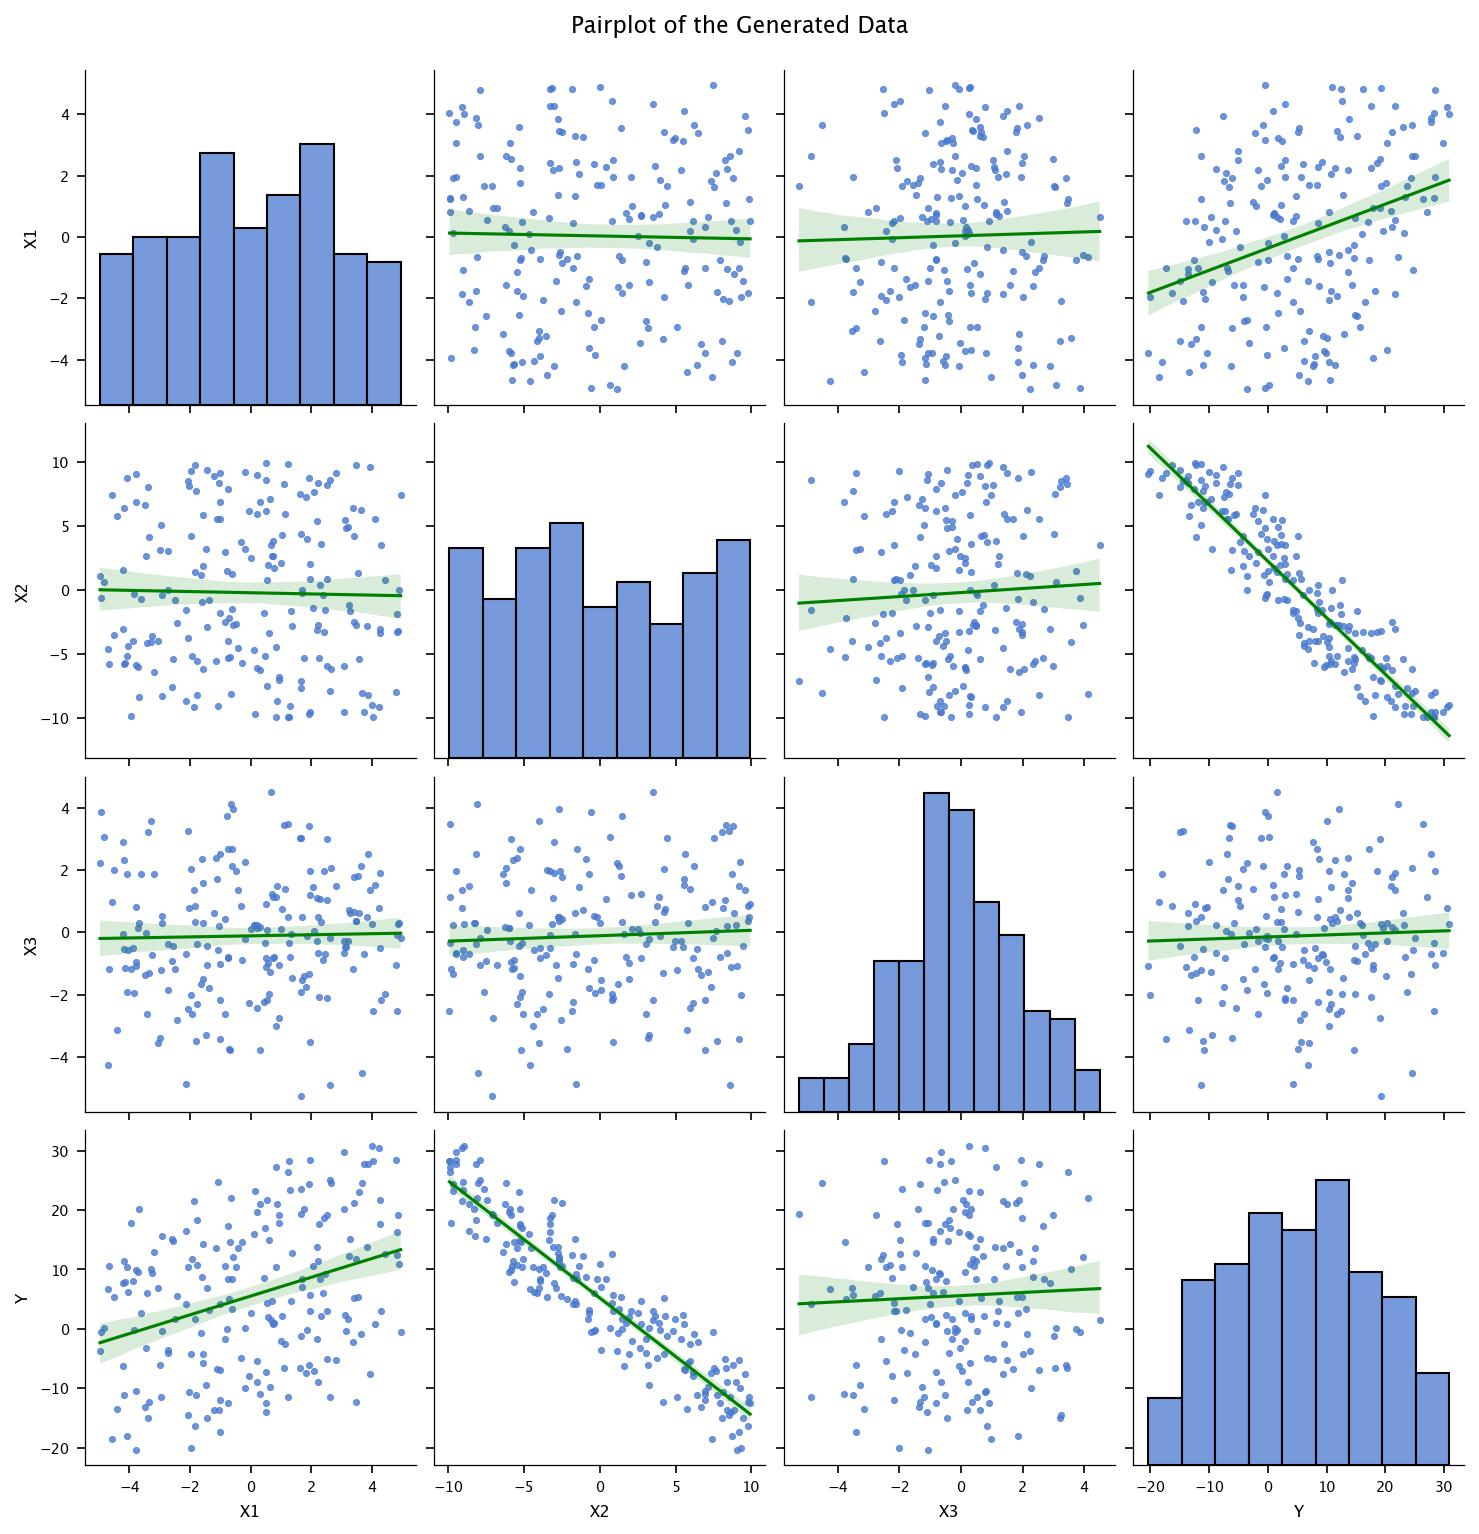

In [3]:
print(df.describe())
sns.pairplot(df, kind='reg', plot_kws={'line_kws':{'color':'green'}})
plt.suptitle("Pairplot of the Generated Data", y=1.02)
plt.show()

## Ordinary Least Squares (OLS) – Manual Computation Using Matrix Algebra

We begin by specifying the standard linear regression model in matrix form:

$$
Y = X \boldsymbol{\beta} + \boldsymbol{\epsilon},
$$

where:  
- $\mathbf{Y}$ is an $N \times 1$ vector of observed responses,  
- $X$ is an $N \times p$ *design matrix*, which includes a column of ones to account for the intercept,  
- $\boldsymbol{\beta}$ is a $p \times 1$ vector of regression coefficients (including the intercept),  
- $\boldsymbol{\epsilon}$ is an $N \times 1$ vector of errors or residuals.

The goal of Ordinary Least Squares is to find the vector $\hat{\boldsymbol{\beta}}$ that minimizes the sum of squared residuals. There is a well-known closed-form solution for this optimization problem, given by:

$$
\hat{\boldsymbol{\beta}} = (X^\top X)^{-1} X^\top Y.
$$

This formula provides the best linear unbiased estimator (BLUE) of the coefficients under standard assumptions (linearity, independence, homoscedasticity, and normally distributed errors).

In the following steps, we will:

1. Manually construct the design matrix $X$, ensuring it includes a column of ones for the intercept.
2. Compute the estimated coefficients $\hat{\boldsymbol{\beta}}$ using NumPy’s matrix operations, specifically `np.linalg.inv(...)`.
3. Compare the computed estimates with the known or true values of the coefficients (`beta_true`) used to generate the data.
4. Validate our manual computation by comparing it to the output from the `statsmodels` OLS implementation.

In [4]:
X_mat = np.column_stack([
    np.ones(N),
    df['X1'].values,
    df['X2'].values,
    df['X3'].values
]) 

y_vec = df['Y'].values.reshape(-1,1)

print("X_mat shape:", X_mat.shape)
print("y_vec shape:", y_vec.shape)

X_mat shape: (200, 4)
y_vec shape: (200, 1)


In [5]:
XTX = X_mat.T @ X_mat
XTX_inv = np.linalg.inv(XTX)
XTy = X_mat.T @ y_vec
beta_hat_manual = XTX_inv @ XTy

beta_hat_manual = beta_hat_manual.flatten()

pprint("\\text{Manual OLS estimates}:", beta_hat_manual)
pprint("\\text{True coefficients}:", beta_true)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

We see the manually computed OLS estimates are close to the true ones.

### Comparison with statsmodels
We'll let `statsmodels` compute OLS, then compare the results in detail.

```{margin}
Note, concretely, you are expected to be able to compute all the algorithms _by hand_, meaning, _in plain `Python` code_. However, in real-life, you can of course use the existing libraries, and knowing the most common ones is part of the basic knowledge expected from a modern data scientist.
```

In [6]:
X_design_sm = sm.add_constant(df[['X1','X2','X3']])
model_ols = sm.OLS(df['Y'], X_design_sm).fit()
print(model_ols.summary())

beta_hat_sm = model_ols.params.values
print("statsmodels OLS:", beta_hat_sm)
print("Manual OLS:", beta_hat_manual)

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     2657.
Date:                Sat, 12 Apr 2025   Prob (F-statistic):          2.01e-158
Time:                        23:29:18   Log-Likelihood:                -415.03
No. Observations:                 200   AIC:                             838.1
Df Residuals:                     196   BIC:                             851.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2043      0.138     37.720      0.0

### Observations
- The _plain `Python`_ results match `statsmodels` results (modulo tiny numerical differences).
- Both are near the true coefficients `(5.0, 1.5, -2.0, 0.5)`.

## Residual Analysis and Tests
Once we have the fitted model, let's analyze **residuals**:

$$
  e_i = y_i - \hat{y}_i.
$$

In [7]:
residuals = model_ols.resid
fitted_vals = model_ols.fittedvalues

When evaluating the quality of a regression model, it is crucial to check whether the underlying assumptions hold. Two common residual diagnostic plots are:
- The residuals vs. fitted plot
- The QQ-plot.

We present both in details in the following sections.

### Residuals vs. Fitted Plot
- **Purpose**: This plot helps detect **non-linearity** and **heteroscedasticity** (unequal variance of residuals).
- **How it works**:
  - The **x-axis** represents the fitted (predicted) values from the regression model.
  - The **y-axis** represents the residuals (errors).
  - Ideally, the residuals should be randomly scattered around zero, forming a **homogeneous "cloud"**.
- **Interpretation**:
  - If a clear pattern (e.g., a curve) appears, it suggests **non-linearity**, meaning the model might be missing key features or transformations.
  - If the spread of residuals **increases or decreases systematically**, it indicates **heteroscedasticity**, meaning the variance of errors is not constant, which violates regression assumptions.

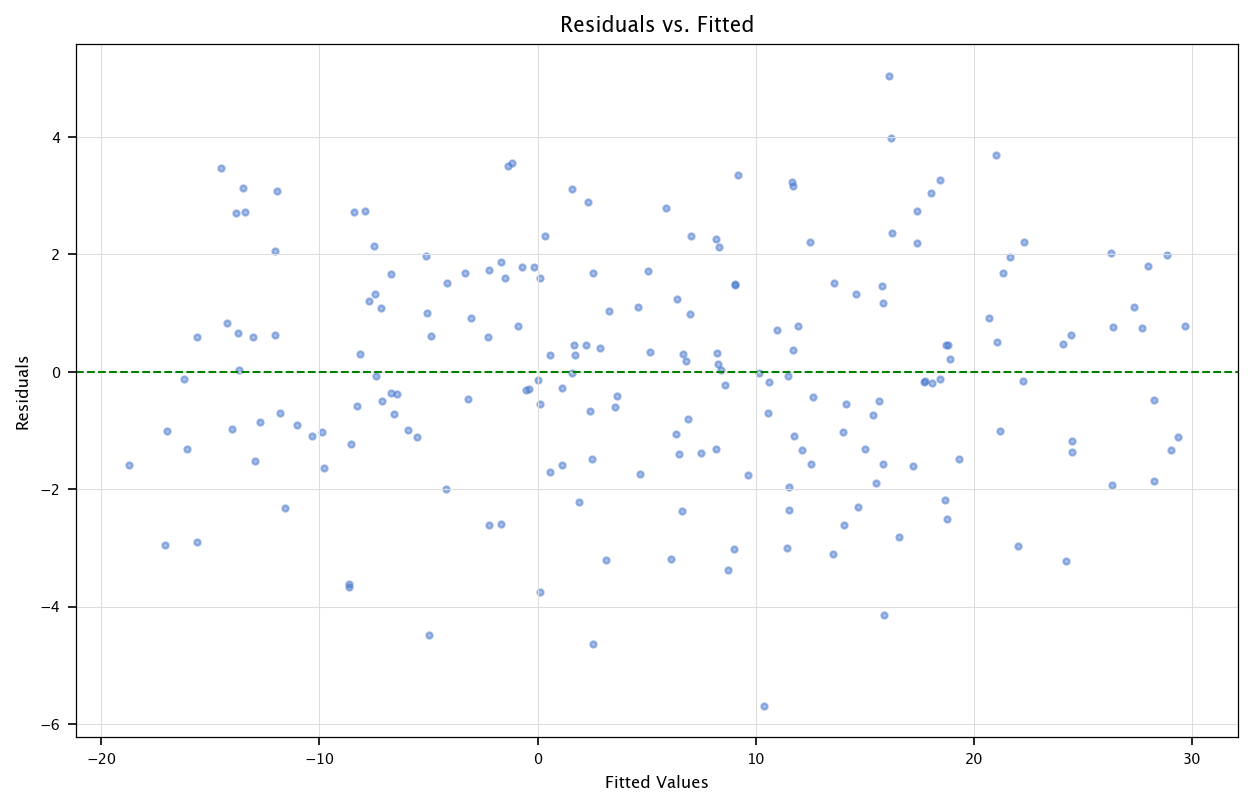

In [8]:
plt.figure(figsize=(10, 6))
plt.scatter(fitted_vals, residuals, alpha=0.5)
plt.axhline(y=0, color='green', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted")
plt.grid("on")
plt.show()

### Normal Q-Q Plot (Quantile-Quantile Plot)
- **Purpose**: Checks whether the residuals follow a **normal distribution**, a key assumption in many regression analyses.
- **How it works**:
  - The **x-axis** shows the theoretical quantiles (expected values under normality).
  - The **y-axis** shows the actual quantiles from the residuals.
  - If the residuals are normally distributed, they should closely follow a **straight diagonal line**.
- **Interpretation**:
  - **Straight-line alignment**: Residuals are normally distributed.
  - **Deviations (e.g., S-shape, heavy tails, skewed distribution)**: Suggests non-normal residuals, which might indicate missing variables, skewed data, or influential outliers.

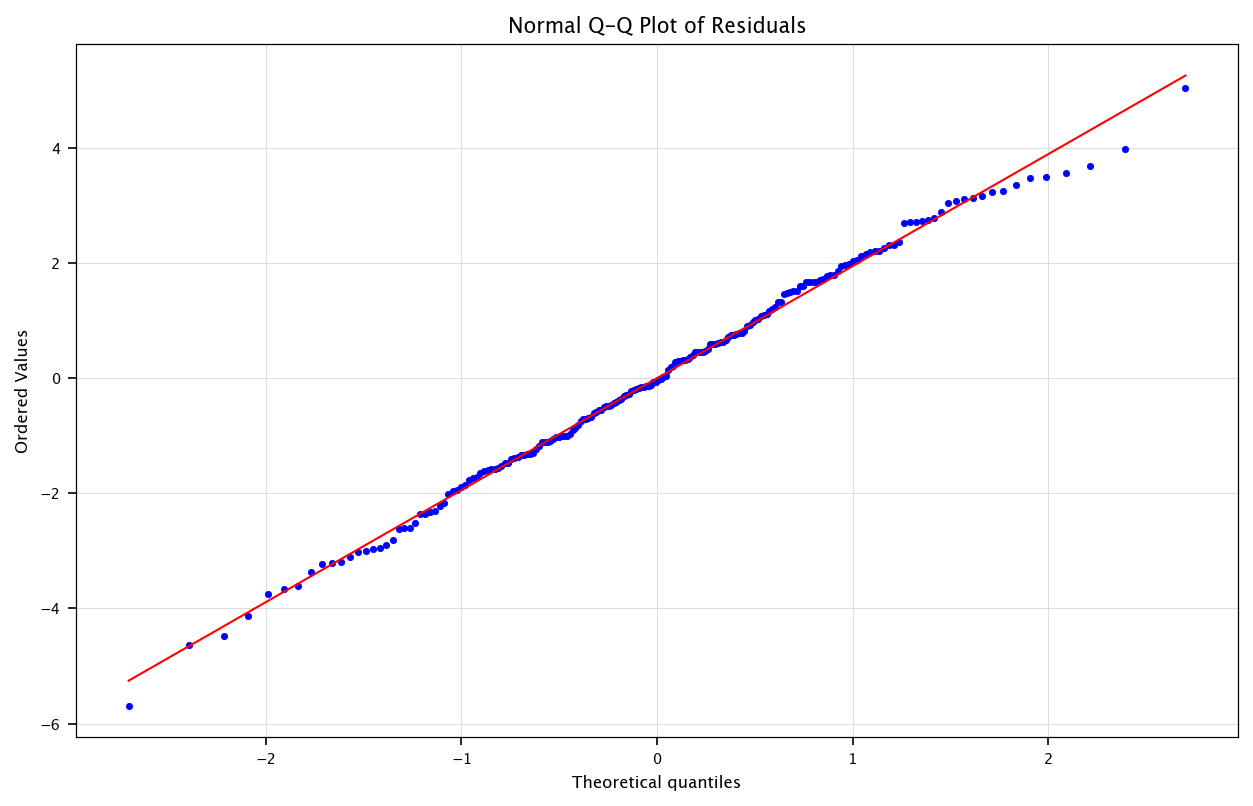

In [9]:
plt.figure(figsize=(10, 6))
probplot(residuals, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot of Residuals")
plt.grid("on")
plt.show()

#### Comments
- Ideally, residuals vs. fitted values have **no clear pattern** and appear _cloud-like_.
- The Q-Q plot should be fairly linear if they are normally distributed.

We can also check the standard deviation or run further tests (e.g., Shapiro-Wilk, Breusch-Pagan for heteroscedasticity) if desired.

## Input Transformations - Polynomial Features

When we talk about **linear regression**, we mean that the model is **linear in parameters**, not necessarily in the input variables $X$. That is, the target variable $y$ is modeled as a **linear combination of parameters**:

$$
y = \beta_0 + \beta_1 f_1(X) + \beta_2 f_2(X) + \dots + \beta_n f_n(X) + \epsilon
$$

where:
- $ \beta_0, \beta_1, \dots, \beta_n $ are the regression coefficients.
- $ f_i(X) $ are **functions of the input features** (which can be non-linear transformations like squares or interaction terms).
- $ \epsilon $ is the error term.

### Example: Still a Linear Model
Even if we introduce **non-linear transformations** of $X$, as long as the model is **linear in the parameters** $ \beta_i $, it is still considered a **linear model**. For example:

$$
y = \beta_0 + \beta_1 X + \beta_2 X^2 + \epsilon
$$

This model includes a quadratic term ($X^2$), but is still a **linear regression model** because it remains a linear combination of the parameters $\beta_0, \beta_1, \beta_2$.

### What Would NOT Be a Linear Model?
A regression model becomes **non-linear in parameters** if the parameters appear in a non-linear way. For example:

$$
y = \beta_0 + e^{\beta_1 X} + \epsilon
$$

or

$$
y = \frac{1}{\beta_0 + \beta_1 X} + \epsilon
$$

These models are **non-linear in parameters** because the relationship between $y$ and the $\beta$ coefficients is no longer a simple linear combination.

## Why Use Polynomial Features in Linear Regression?
Since linear regression allows us to use **non-linear transformations of $X$** while keeping the model linear in parameters, we can **extend linear regression** to capture more complex relationships.

### Polynomial Feature Expansion
Given original features $ X_1, X_2, X_3 $, we can introduce:
- **Squared terms**: $ X_1^2, X_2^2, X_3^2 $ → captures curvature.
- **Interaction terms**: $ X_1X_2, X_1X_3, X_2X_3 $ → captures relationships between variables.

By expanding the features in this way, we allow a linear regression model to **approximate non-linear patterns** in the data, making it more flexible while maintaining its interpretability.

### Example
A second-degree polynomial regression model:

$$
y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3 + \beta_4 X_1^2 + \beta_5 X_2^2 + \beta_6 X_3^2 + \beta_7 X_1X_2 + \beta_8 X_1X_3 + \beta_9 X_2X_3 + \epsilon
$$

This is still **a linear model in parameters** but now captures non-linear relationships in $X$.

### How to Implement Polynomial Features in Python
In Python, we can generate polynomial features using `sklearn.preprocessing.PolynomialFeatures`.

In [10]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(df[['X1','X2','X3']])
print("Original shape:", df[['X1','X2','X3']].shape)
print("Polynomial shape:", X_poly.shape)

X_poly_mat = np.column_stack([np.ones(N), X_poly])

Original shape: (200, 3)
Polynomial shape: (200, 9)


The OLS is obtained using the same closed-form formulation:

In [11]:
XTX_poly = X_poly_mat.T @ X_poly_mat
XTX_poly_inv = np.linalg.inv(XTX_poly)
XTy_poly = X_poly_mat.T @ y_vec
beta_hat_poly_manual = XTX_poly_inv @ XTy_poly
beta_hat_poly_manual = beta_hat_poly_manual.flatten()

print("Manual OLS (polynomial) shape of beta:", beta_hat_poly_manual.shape)
pprint("\\text{beta\_hat\_poly\_manual}:", beta_hat_poly_manual)

Manual OLS (polynomial) shape of beta: (10,)


<IPython.core.display.Math object>

We can compare the results offered by `statsmodel`:

In [12]:
X_poly_sm = sm.add_constant(X_poly)
model_poly_sm = sm.OLS(df['Y'], X_poly_sm).fit()
beta_hat_poly_sm = model_poly_sm.params.values

pprint("\\text{Statsmodels polynomial OLS}:", beta_hat_poly_sm)
pprint("\\text{Manual polynomial OLS}:", beta_hat_poly_manual)
print("\nPolynomial OLS summary:\n", model_poly_sm.summary())

<IPython.core.display.Math object>

<IPython.core.display.Math object>


Polynomial OLS summary:
                             OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     872.4
Date:                Sat, 12 Apr 2025   Prob (F-statistic):          2.13e-149
Time:                        23:29:19   Log-Likelihood:                -413.46
No. Observations:                 200   AIC:                             846.9
Df Residuals:                     190   BIC:                             879.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0526     

#### Residual analysis and QQ-plot 

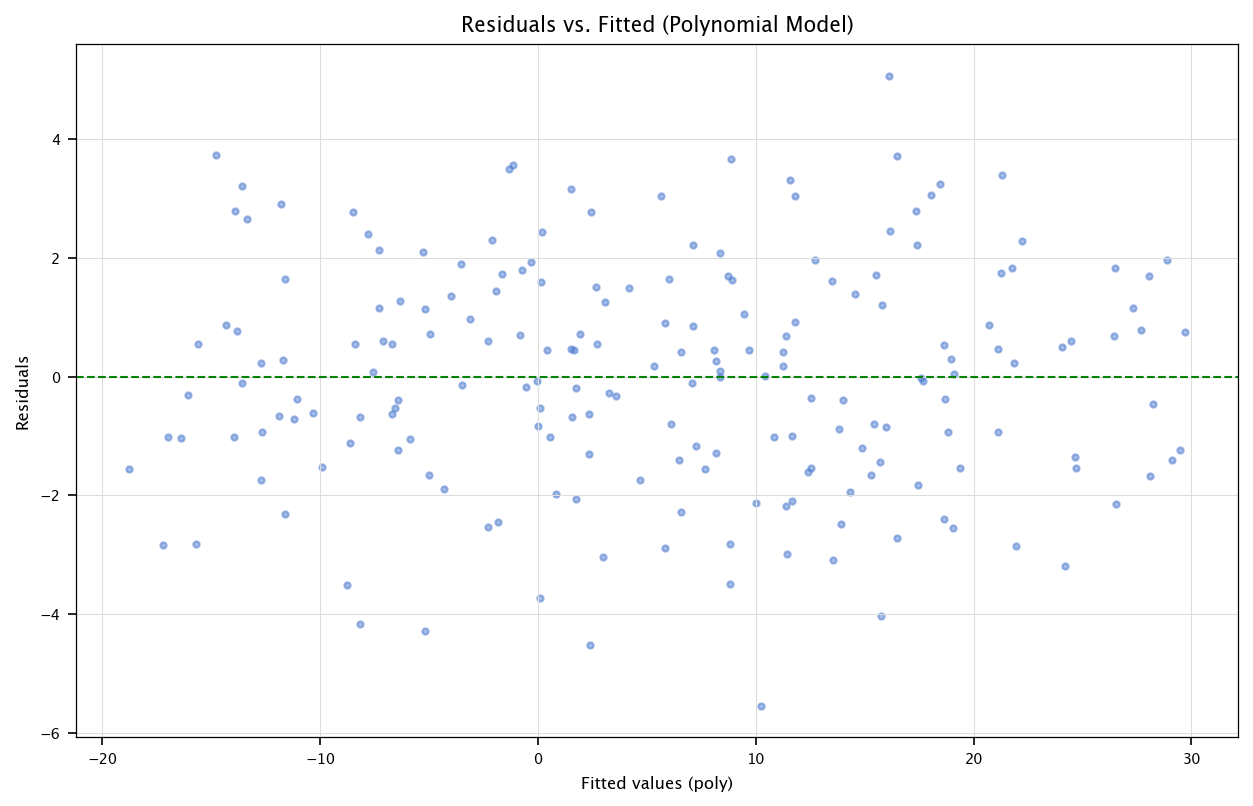

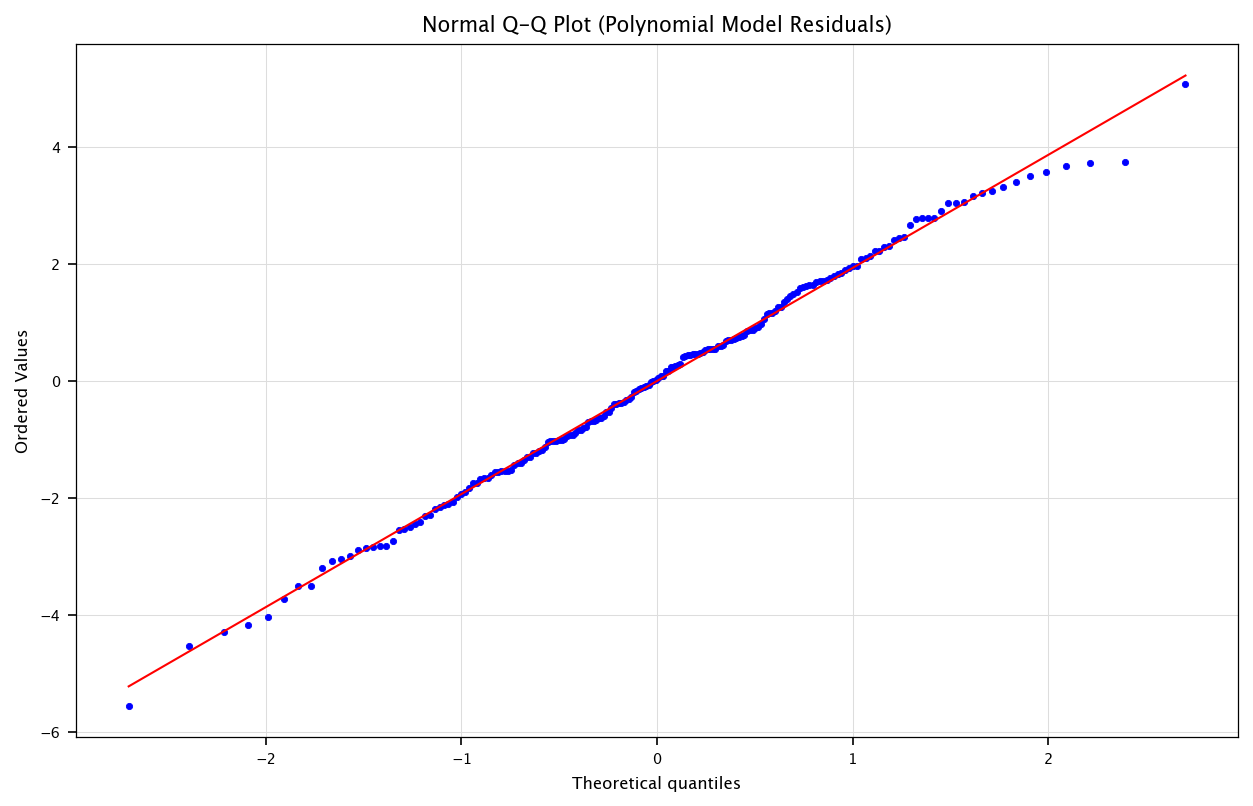

In [13]:
residuals_poly = model_poly_sm.resid
fitted_poly = model_poly_sm.fittedvalues

plt.figure(figsize=(10, 6))
plt.scatter(fitted_poly, residuals_poly, alpha=0.5)
plt.axhline(y=0, color='green', linestyle='--')
plt.xlabel("Fitted values (poly)")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted (Polynomial Model)")
plt.grid("on")
plt.show()

plt.figure(figsize=(10, 6))
probplot(residuals_poly, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot (Polynomial Model Residuals)")
plt.grid("on")
plt.show()

**Interpretation**:
- If the polynomial model captures more structure, we may see less pattern in the residuals plot.
- Alternatively, if the true relationship was already linear, polynomial terms might just overfit or remain insignificant.

## RBF Expansion
Polynomial feature expansion is a powerful tool to introduce **non-linearity** into a linear regression model, but it has several limitations:

- **Feature explosion**: As the polynomial degree increases, the number of new features grows **exponentially**, making models computationally expensive and prone to overfitting.
- **Global transformations**: Polynomial terms like $X^2, X^3$ affect the entire input space, meaning that small changes in $X$ have a large impact everywhere, which might not always be desirable.
- **Poor handling of local variations**: Polynomial functions are not ideal when the relationship between $X$ and $y$ has local variations or is non-smooth.

This is where **Radial Basis Function (RBF) expansion** can be useful.

### What is RBF Expansion?
RBF expansion **maps the original features into a higher-dimensional space** using functions that respond **locally** to the input values.

Instead of using polynomial transformations like:

$$
y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3 + \beta_4 X_1^2 + \beta_5 X_2^2 + \beta_6 X_3^2 + \beta_7 X_1X_2 + ...
$$

We use **random Fourier features** to approximate an RBF kernel, generating transformed variables like:

$$
\Phi(X) = \cos(WX) + \sin(WX)
$$

where $ W $ is a random weight matrix sampled from a Gaussian distribution.

#### Why Use RBF Instead of Polynomial Expansion?
- **Better for local variations**: Unlike polynomials, RBFs can capture **localized** structures in data.
- **Fixed feature size**: The number of transformed features is independent of the input size, making it computationally efficient.
- **Good for high-dimensional data**: Works well when the input space is **high-dimensional** because it avoids feature explosion.

### Implementing RBF Expansion with Random Fourier Features
We use `sklearn.kernel_approximation.RBFSampler` to generate **random Fourier features** that approximate the RBF kernel.

RBF-transformed shape: (200, 50)


                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     146.9
Date:                Sat, 12 Apr 2025   Prob (F-statistic):          5.70e-105
Time:                        23:29:20   Log-Likelihood:                -396.22
No. Observations:                 200   AIC:                             894.4
Df Residuals:                     149   BIC:                             1063.
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -43.4898     19.729     -2.204      0.0

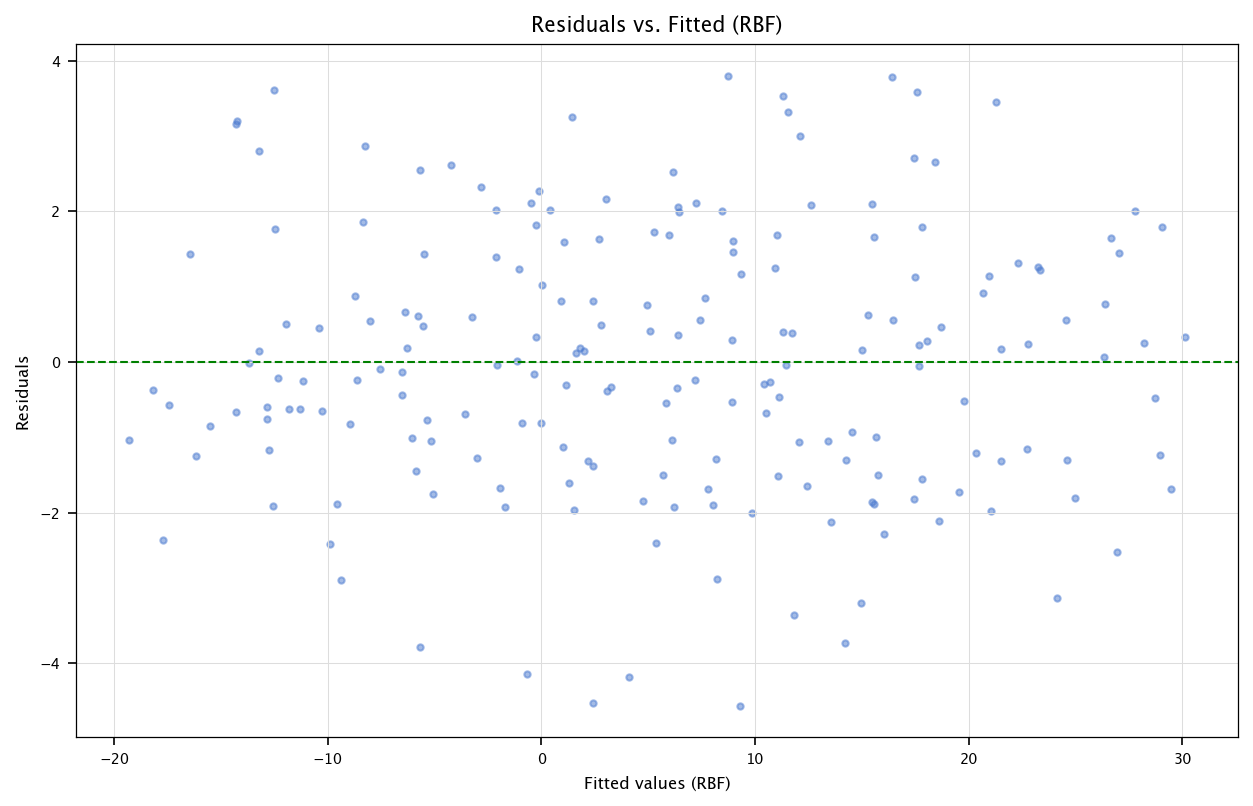

In [14]:
from sklearn.kernel_approximation import RBFSampler

rbf = RBFSampler(gamma=0.05, n_components=50, random_state=123)
X_rbf = rbf.fit_transform(df[['X1','X2','X3']])
print("RBF-transformed shape:", X_rbf.shape)

# We'll do OLS with statsmodels for brevity:
X_rbf_sm = sm.add_constant(X_rbf)
model_rbf_sm = sm.OLS(df['Y'], X_rbf_sm).fit()

print(model_rbf_sm.summary())

resid_rbf = model_rbf_sm.resid
fitted_rbf = model_rbf_sm.fittedvalues

plt.figure(figsize=(10, 6))
plt.scatter(fitted_rbf, resid_rbf, alpha=0.5)
plt.axhline(y=0, color='green', linestyle='--')
plt.xlabel("Fitted values (RBF)")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted (RBF)")
plt.grid("on")
plt.show()

#### Comments
- Each RBF feature is basically a sinusoidal basis function in random projection space.
- We could also attempt a manual approach:
   
  $$
    \hat{\beta} = (X_{\mathrm{rbf}}^\top X_{\mathrm{rbf}})^{-1} X_{\mathrm{rbf}}^\top y
  $$
  
  if we want to replicate the normal equation style. 
- The dimensionality (50) can be large, so be mindful of potential numerical issues and overfitting.

## Ridge Regression
For complex expansions (like polynomial of high degree or many RBF components), **overfitting** can happen. 
Ridge regression adds an L2 penalty:

$$
  \min_{\beta} \;\; \| Y - X \beta \|^2 + \alpha \| \beta \|^2.
$$

### Ridge Closed-form

Ridge also has a known closed-form:

$$
  \hat{\beta}_{\mathrm{ridge}} = (X^\top X + \alpha I)^{-1} X^\top Y.
$$

We'll show a manual solution, then compare to scikit-learn. We'll do it on the **polynomial features** for illustration.

In [15]:
alpha_ridge = 10.0
I_p = np.eye(X_poly_mat.shape[1])  # dimension p x p, where p = number of poly features + 1 (intercept)

# Usually we do not regularize the intercept, so we might set I_p[0,0] = 0.
# Let's do that to avoid shrinking the intercept:
I_p[0,0] = 0.0

XTX_ridge = X_poly_mat.T @ X_poly_mat + alpha_ridge*I_p
XTX_ridge_inv = np.linalg.inv(XTX_ridge)
XTy_ridge = X_poly_mat.T @ y_vec
beta_hat_ridge_manual = XTX_ridge_inv @ XTy_ridge
beta_hat_ridge_manual = beta_hat_ridge_manual.flatten()

print("Manual Ridge (polynomial) shape:", beta_hat_ridge_manual.shape)
pprint("\\text{Manual Ridge Coeffs}:", beta_hat_ridge_manual)

Manual Ridge (polynomial) shape: (10,)


<IPython.core.display.Math object>

In [16]:
from sklearn.linear_model import Ridge

ridge_sklearn = Ridge(alpha=alpha_ridge, fit_intercept=False) 
# "fit_intercept=False" because we already included the intercept column in X_poly_mat
# We will manually set the intercept to match the first column or we can remove intercept from X_poly_mat.

ridge_sklearn.fit(X_poly_mat, df['Y'])
beta_hat_ridge_sklearn = ridge_sklearn.coef_

pprint("\\text{scikit-learn Ridge Coeffs}:", beta_hat_ridge_sklearn)
pprint("\\text{Difference (manual - sklearn)}:", (beta_hat_ridge_manual - beta_hat_ridge_sklearn))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

They should be nearly identical (tiny floating discrepancies may occur).

### Residual analysis for Ridge

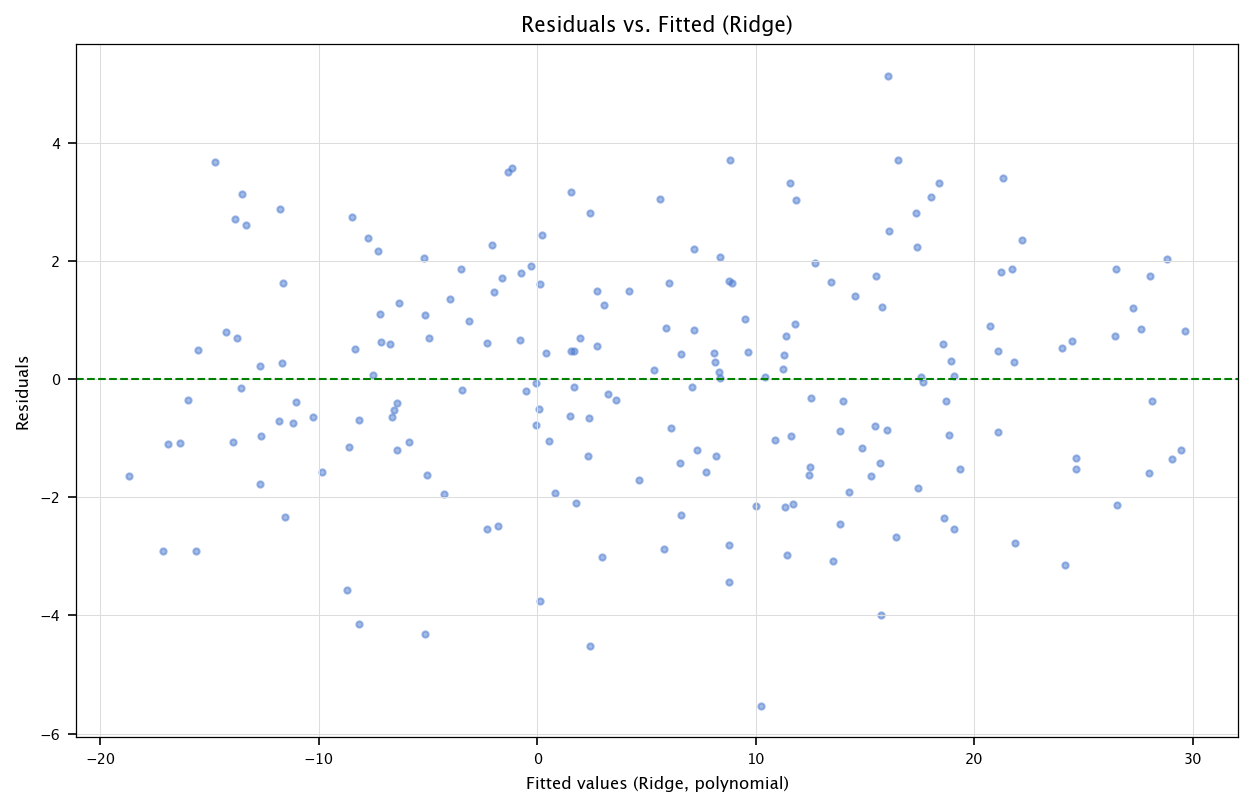

In [17]:
y_pred_ridge = X_poly_mat @ beta_hat_ridge_manual
resid_ridge = df['Y'] - y_pred_ridge

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_ridge, resid_ridge, alpha=0.5)
plt.axhline(y=0, color='g', linestyle='--')
plt.xlabel("Fitted values (Ridge, polynomial)")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted (Ridge)")
plt.grid("on")
plt.show()

**Remarks**:
- As alpha_ridge increases, the polynomial coefficients shrink more, typically reducing variance (but possibly increasing bias).
- We can further use cross-validation to select alpha automatically or do a hyperparameter grid.

## Conclusion

This chapter has provided a comprehensive, hands-on exploration of linear models—starting from the manual derivation of the Ordinary Least Squares (OLS) estimator to the application of regularization techniques and feature transformations. Through synthetic data, we validated the accuracy of our estimators, examined residuals for assumption-checking, and used diagnostic plots to evaluate model fit.

We have seen how linear regression, while conceptually straightforward, remains a powerful modeling tool when used thoughtfully. The incorporation of polynomial and radial basis function expansions extends the expressive capacity of linear models, enabling them to approximate complex, non-linear relationships without abandoning interpretability.

We also introduced Ridge regression, which provides a principled approach to combat overfitting and multicollinearity, especially in high-dimensional settings. This regularized extension highlights a key transition in statistical learning: balancing model flexibility with generalization performance.

Ultimately, this chapter emphasizes not only how to implement linear models, but how to critically assess their assumptions and limitations. These foundational skills will be essential as we move on to more sophisticated models in the chapters ahead.